# Injecting Model Astrophysical Signals into Light Curves to Test Retrieval

When the second reaction wheel broke on the Kepler mission, the telescope was reborn as K2. Instead of relying on 3 reaction wheels for stable pointing, K2 relies on two reaction wheels and solar radiation pressure. Unfortunately, this is not as accurate as 3 wheel pointing. K2 has additional motion from the spacecraft. You can see the motion by sliding in the interact tool below.

In [33]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
tpf = KeplerTargetPixelFile.from_archive(247887989, verbose=False) #K2-133b
tpf.interact()

Loading BokehJS ...

HBox(children=(Play(value=140878, description='Press play', interval=10, max=144821, min=140878, show_repeat=False), IntSlider(value=140878, description='Cadence', layout=Layout(height='20px', width='40%'), max=144821, min=140878), FloatRangeSlider(value=(1.1560160947087952, 3.4023702867510797), continuous_update=False, description='Pixel Stretch (log)', layout=Layout(height='20px', width='30%'), max=4.5511956214904785, min=-0.5103619694709778, step=0.016871859232584635, style=SliderStyle(description_width='initial'))))

Output()

This motion causes a significant noise in K2 data. The source of this noise is the *subpixel flat field*. In brief: all pixels are not identically sensitive. As the target moces over different pixels, the flux contribution changes.

There are corrections for this noise which can be extremely powerful. See below for an example with K2-133b. Without SFF, it is impossible to detect the exoplanet.

100%|██████████| 20/20 [00:01<00:00, 17.09it/s]


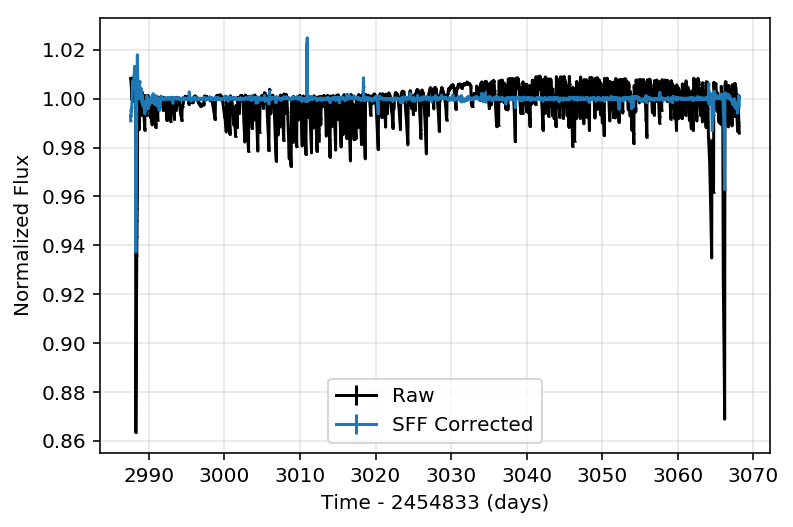

In [34]:
lc = tpf.to_lightcurve()
ax = lc.plot(label='Raw')
lc.correct(windows=20).plot(ax=ax, label='SFF Corrected')

100%|██████████| 20/20 [00:00<00:00, 24.96it/s]


(0.995, 1.004)

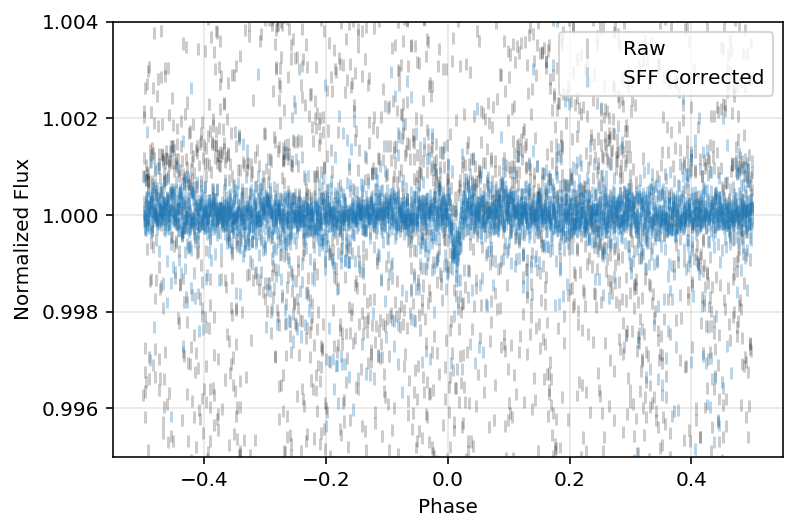

In [46]:
lc = tpf.to_lightcurve()
ax = lc.fold(period=3.0712).plot(label='Raw', ls='', alpha=0.2)
lc.correct(windows=20).fold(period=3.0712).plot(ax=ax, label='SFF Corrected', ls='', alpha=0.3)
plt.ylim(0.995, 1.004)

As you can see above, SFF detrending has a significant effect on the light curve. However, there is no clear way to choose which SFF parameters are best for each users purpose. It is also unclear at what point the detrending is overfitting and removing true astrophysical signal. 

*For users to be able to use SFF to detrend K2 data, we must be able to know at what point we are overfitting.*

## What's the problem?

Motion detrending methods, such as SFF, can be somewhat black boxes. Users choose the detrending parameters that, at least visually, remove the motion. However it is very difficult to understand when we are **over correcting** the K2 motion. Over correcting can mean that we are destroying real signal from transiting exoplanets.

To really be able to test the effects of overfitting and find the best parameters for detrending we need **signal injection**. This has two key benefits.

* We can tell the community which detrending parameters they should use for any given astrophysical signal
* We can give realistic errors on retrieved exoplanet parameters when detrending has been used.

## What is Signal Injection

Signal injection is where we take a physically relevant astrophysical model, (such as a transit model) and artificially inject it into our data. This might be done at the *pixel level*, which requires knowledge of the background noise and PSF, or the *light curve level*. We suggest you start at the light curve level, which is easier.

## What is the goal of this project?

**To develop a lightkurve routine to inject physically relevant transit models into data. Using that routine, test the effect of SFF detrending.**

## You will need...

`lightkurve` does not currently have any routines for signal injection. Over the course of the next ten weeks we would like you to develop some easy to use facilities to do this. To begin with, over the first few weeks

* Learn the basics of `lightkurve` and github. Fix one of the open issues that your supervisor will give you.
* Learn the basics of the SFF routines in lightkurve by fitting a set of exoplanet host stars. What does each parameter do to the retrieved exoplanet parameters.
* Use `batman`, `scipy` and `emcee` to fit a transit model to each of your detrended light curves. Note there is currently no routine to do this in lightkurve, but this would be an excellent addition. Work closely with Gully to make sure you understand the best way to fit a model to data. Alternately, see if you can find transit *fitting* (not transiting *modeling*) routines that you can use or work from.

In the next few weeks, you should aim to

* Discuss with your supervisor and come up with a plan for how to build the injection API. What do users need? What have you found useful in your investigations? Make sure it fits in with the rest of lightkurve
* Begin prototyping the injection facility. 
* You should start with transit models, however make sure your routines are flexible. In the future, we may want to add flare models and supernovae models.

Once you have a working prototype for your injection tool

* Build unit tests! All `lightkurve` routines need unit tests.
* Build a tutorial. Make sure that your colleagues (and supervisor) can follow it. Take their feedback and apply any improvements. 

Once you have a stable version of the injection tool

* Inject a random set of exoplanets to a set of light curves.
* Run BLS on all your injected parameters, what do you retrieve? Are all parameters retrieved the same? What errors do you get on period? Which planets are lost?
* Run your transit fitting routines from the first few weeks. What exoplanet parameters do you retrieve? What is the effect on the retrieved radius?
* Use current work on planet occurence rates to build a physically relevant set of injected planets. When the planets are found using BLS, what effect do different SFF parameters have on the retrieved occurrence rates?

Once you have an injection tool built, there are *plenty* of science directions to go by testing detrending in K2 and how it effects planet parameters and occurrence rates. I've only highlighted a few above.

## Some tools to help you

If you are confused about any aspect of the Kepler telescope or any systematic, the first place to look is the [Kepler Instrument Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19033-001.pdf). It is a very large manual, but a quick search in it usually turns up the answer.

I recommend reading [Demystifying Kepler Data](https://arxiv.org/pdf/1207.3093.pdf), which is a short read and easy to digest. This will explain a little about the systematics and how we use Cotrending Basis Vectors to correct for them.

For this project, I recommend you read Andrew Vanderburg's paper on SFF. A nice gateway to this is Gully's excellent SFF tutorial, which you can watch [here](https://www.youtube.com/watch?v=kYRqZwz2VPU&t=28s).

I recommend Laura Kreidbergs `batman` package for transit modeling. You can read more about it [here](https://www.cfa.harvard.edu/~lkreidberg/batman/). This is a sophisticated and fast package, do **not** reinvent the wheel trying to build your own transit model.

For fitting transit models and propagating realistic uncertainties, I recommend scipy optimize and Dan Foreman Mackay's [emcee](http://dfm.io/emcee/current/). You can talk with Gully for more information on how to fit models to data.

For BLS, try using DFM's [bls.py](https://github.com/dfm/bls.py). This *should* be being merged into astropy soon. Keep an eye on [this](https://github.com/astropy/astropy/pull/7391) pull request to see when it's merged.